# SUP ML 2 - MODEL

# Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats 
from scipy.stats import randint as sp_randint

# Modelizacion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
# Evaluacion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer,roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score
from sklearn import metrics
from xgboost import plot_tree
import shap
from scipy.stats import pearsonr

from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

# Carga clean data

In [21]:
df = pd.read_csv('.\\data\\df_clean.csv')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Columns: 178 entries, rev to creditcd_desconocido
dtypes: bool(144), float64(29), int64(5)
memory usage: 35.7 MB


# Split X-y

In [23]:
#Dividimos el split X-y

target = 'churn'
features = df.columns[df.columns != target]

In [24]:
target

'churn'

In [25]:
X = df[features]
y = df[target]

# Distribución del target

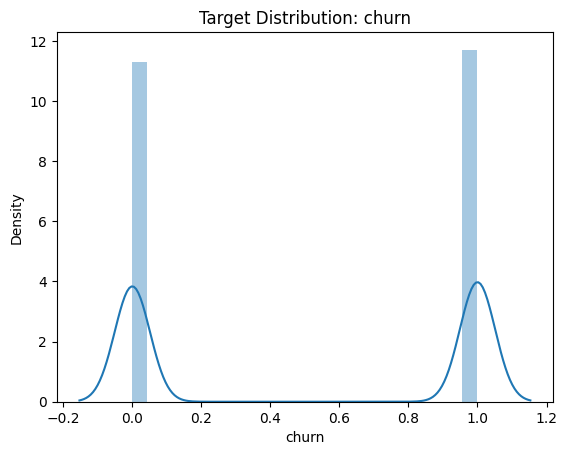

In [26]:
sns.distplot(y)
plt.title('Target Distribution: '+target)
plt.show()

# Undersampling (*)

**NOTA:** SOLO EN CLASIFICACIÓN cuando el ratio de éxitos está MUY DESBALANCEADO (<10%).

In [27]:
df["churn"].value_counts()

churn
1    45800
0    44200
Name: count, dtype: int64

# Split TRAIN-TEST

In [28]:
# Divide X-y en Train (80%) y Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
X_train.shape

(72000, 177)

In [30]:
y_train

51004    0
11453    0
9691     0
51992    0
23531    1
        ..
6265     0
54886    1
76820    0
860      0
15795    0
Name: churn, Length: 72000, dtype: int64

In [31]:
print('Train set size:',X_train.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 72000
Test set size: 18000


# Rescaling

* NO NECESARIO en modelos de Arboles de Decisión.
* Guardar scaler en el model path.

In [32]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns, index= X_test.index)

In [33]:
# Comentado para no ejecutarlo cada vez que relancemos el codigo

# pickle.dump(scaler, open('my_scaler.pkl', 'wb'))

In [34]:
#X_train_std.to_csv(".\\model\\X_train_std.csv")
#X_test_std.to_csv(".\\model\\X_test_std.csv")

# TRAIN-VALIDA

## Torneo de Modelos

* Probamos una colección de modelos con el objetivo de conseguir el mejor rendimiento del modelo en los datos de VALIDACION.

In [35]:
# Calculo del AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])  

# Calculo del AUC de un modelo sobre un dataset con Cross-Validation (X-y). Args: modelo a validar, X, y  
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model, 
                              X, y, 
                              cv=4,                 # Numero de folds que vamos a utilizar para validar 
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )    
  return cross_val.mean()

In [36]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs: 
#   * modelo
#   * (X,y) 
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)
  
  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)   
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

In [37]:
#Modelos a usar

    # LogisticRegression(),
    # AdaBoostClassifier(),
    # Ridge(),
    # RandomForestClassifier(),
    # XGBClassifier(),
    # GradientBoostingClassifier(),
    # DecisionTreeClassifier(),
    # BaggingClassifier(),
    # RandomForestClassifier()


In [38]:
evaluate_classification(model = AdaBoostClassifier(), 
                        X = X_train, 
                        y = y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.663938,0.656981


In [39]:
evaluate_classification(model = LogisticRegression(), 
                        X = X_train_std, 
                        y = y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.663938,0.656981
1,LogisticRegression(),0.626493,0.619905


In [40]:
evaluate_classification(model = BaggingClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
0,AdaBoostClassifier(),0.663938,0.656981
1,LogisticRegression(),0.626493,0.619905
2,BaggingClassifier(),0.999020,0.617101


In [41]:
evaluate_classification(model = GradientBoostingClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.685749,0.670426
0,AdaBoostClassifier(),0.663938,0.656981
1,LogisticRegression(),0.626493,0.619905
2,BaggingClassifier(),0.999020,0.617101


In [42]:
evaluate_classification(model = RandomForestClassifier(), X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.685749,0.670426
0,AdaBoostClassifier(),0.663938,0.656981
4,RandomForestClassifier(),1.000000,0.656797
1,LogisticRegression(),0.626493,0.619905
2,BaggingClassifier(),0.999020,0.617101


In [43]:
evaluate_classification(model = XGBClassifier(), 
                        X=X_train, y=y_train)

,Model,AUC Train,AUC Cross-Valida
3,GradientBoostingClassifier(),0.685749,0.670426
5,"XGBClassifier(base_score=None, booster=None, c...",0.826803,0.670395
0,AdaBoostClassifier(),0.663938,0.656981
4,RandomForestClassifier(),1.000000,0.656797
1,LogisticRegression(),0.626493,0.619905
2,BaggingClassifier(),0.999020,0.617101


In [44]:
evaluate_classification(model = lgb.LGBMClassifier(), 
                        X=X_train, y=y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36634, number of negative: 35366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508806 -> initscore=0.035226
[LightGBM] [Info] Start training from score 0.035226
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27476, number of negative: 26524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

,Model,AUC Train,AUC Cross-Valida
6,LGBMClassifier(),0.742749,0.680810
3,GradientBoostingClassifier(),0.685749,0.670426
5,"XGBClassifier(base_score=None, booster=None, c...",0.826803,0.670395
0,AdaBoostClassifier(),0.663938,0.656981
4,RandomForestClassifier(),1.000000,0.656797
1,LogisticRegression(),0.626493,0.619905
2,BaggingClassifier(),0.999020,0.617101


USAREMOS LGBM YA QUE ES EL QUE MAYOR AUC NOS HA DADO EN VALIDACIÓN Y EL QUE A SU VEZ MAS SE APROXIMA AL ENTRENAMIENTO

* Utilizar RandomSearch para probar diferentes configuraciones de los parametros del modelo ganador en el torneo de modelos con el objetivo de mejorar el control del overfitting.

In [45]:
parametros_hp = {
    'num_leaves': sp_randint(6, 50),
    'min_child_samples': sp_randint(10, 50),
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20]
}

In [46]:
search_hp = RandomizedSearchCV(estimator = lgb.LGBMClassifier(), 
                               param_distributions = parametros_hp,
                               scoring = 'roc_auc',                         # metrica a optimizar: AUC
                               cv = 4,                                      # numero de folds para cross-validation
                               n_iter = 100,                                 # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1, 
                               verbose=True)

In [47]:
search_hp.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36634, number of negative: 35366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508806 -> initscore=0.035226
[LightGBM] [Info] Start training from score 0.035226


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000201650199D0>,
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 10.0, 100.0,
                                                             1000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020157AC5450>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=True)

In [48]:
print("---- Results from Random Search -----")
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC:", search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: LGBMClassifier(min_child_samples=26, min_child_weight=10.0, num_leaves=49,
               reg_alpha=5, reg_lambda=0.1, subsample=0.8)

 The best AUC: 0.6845981622624857

 The best parameters across ALL searched params:
 {'colsample_bytree': 1.0, 'min_child_samples': 26, 'min_child_weight': 10.0, 'num_leaves': 49, 'reg_alpha': 5, 'reg_lambda': 0.1, 'subsample': 0.8}


## Modelo final

* Entrenar el modelo final con el algoritmo y los parametros que hanfuncionado mejor en anteriores experimentos.
* Argumentar la elección.
* Guardar el modelo en model path.

In [49]:
best_model = search_hp.best_estimator_

In [50]:
print('AUC Train:', auc(best_model, X_train, y_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36634, number of negative: 35366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508806 -> initscore=0.035226
[LightGBM] [Info] Start training from score 0.035226
AUC Train: 0.7589962408124784


In [51]:
print('AUC CV:', auc_cross_validation(best_model, X_train, y_train))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27476, number of negative: 26524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5550
[LightGBM] [Info] Number of data points in the train set: 54000, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508815 -> initscore=0.035263
[LightGBM] [Info] Start training from score 0.035263
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27476, number of negative: 26524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5553
[LightGBM] [Info

In [52]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)                # predicciones del modelo en los datos de TEST

In [53]:
#Igual que con el Scaler, lo comentamos para que no lo este generando de nuevo cada vez

#pickle.dump(best_model, open('my_model.pkl', 'wb'))

# TEST

* Evaluación de las métricas de performance en TEST.

In [54]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
matriz_confusion = confusion_matrix(y_test, y_test_pred)

In [55]:
# Crear un diccionario con los nombres de las métricas y sus valores
metricas_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

# Imprimir las métricas
for nombre_metrica, valor_metrica in metricas_dict.items():
    print(f'{nombre_metrica}: {valor_metrica:.4f}')

# Imprimir la matriz de confusión
print('\nMatriz de Confusión:')
print(matriz_confusion)

Accuracy: 0.6307
Precision: 0.6309
Recall: 0.6624
F1 Score: 0.6463
ROC AUC: 0.6301

Matriz de Confusión:
[[5281 3553]
 [3094 6072]]


# INTERPRETABILITY

* Analizamos top features del modelo y su peso en el modelo.
* Plotear SHAP values y el impacto positivo/negativo.
* Comentar las top5 features, su impacto en el target y extraer insights.
* Analisis complementarios:
  * Modelos de arboles: Feature Importances, plot de arbol de decision.
  * Modelos lineales: Coeficentes y formula del modelo.

In [56]:
model.coef_

NameError: name 'model' is not defined

In [ ]:
df_coef = pd.DataFrame({'FEATURE':X.columns.values,
            'COEFFICIENT': model.coef_}).sort_values('COEFFICIENT',ascending=False)
sns.barplot(data=df_coef, y='FEATURE',x='COEFFICIENT',color='skyblue')
plt.title('Feature importance (weights)')
plt.show()

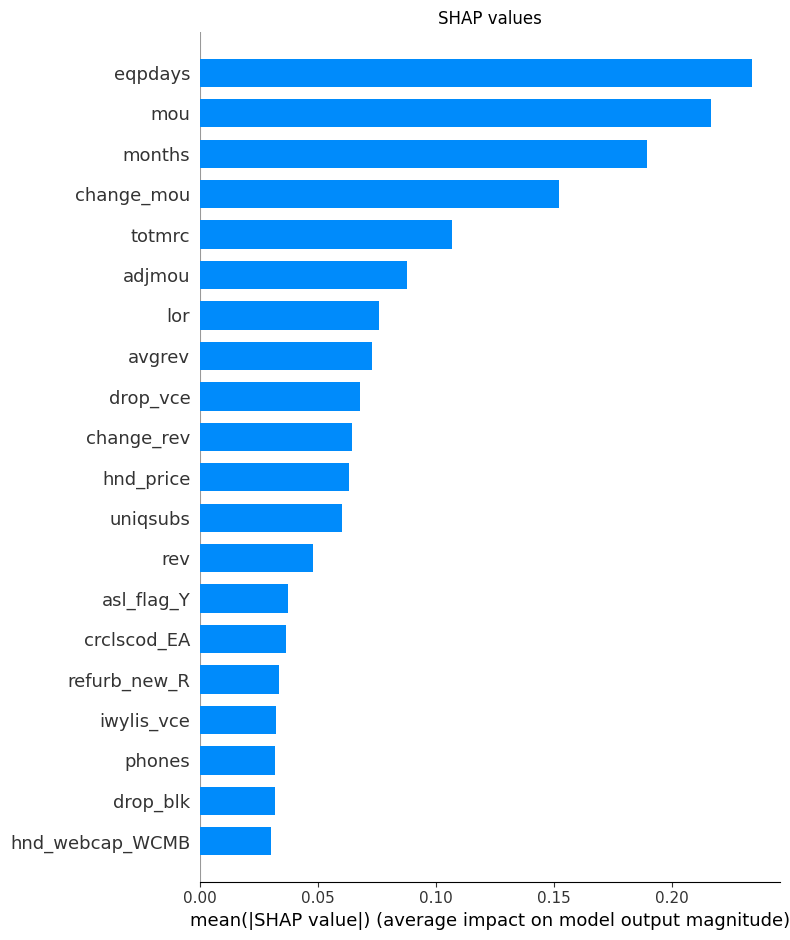

In [77]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

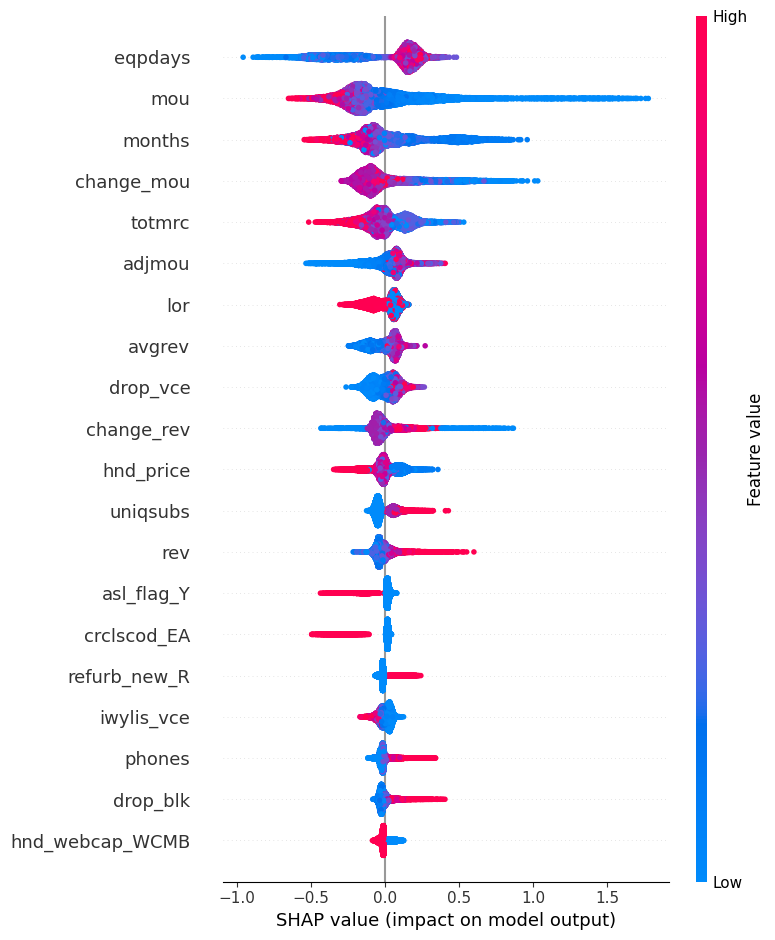

In [78]:
shap.summary_plot(shap_values, X_test)